<a href="https://colab.research.google.com/github/PranavSuresh525/AI-ML-Projects/blob/main/AI_Integration_in_Finance%5CNvidia_Stock_Predictor_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## import all files
import torch
from torch import nn
from google.colab import files
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
## device agnostic code
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Upload CSV from local machine
uploaded = files.upload()
# Read the uploaded CSV file
df = pd.read_csv("Nvidia stock price trend.csv")
data=df["Close"].values.reshape(-1,1)
scaler=MinMaxScaler(feature_range=(-1,1))
scaled_data=scaler.fit_transform(data)

Saving Nvidia stock price trend.csv to Nvidia stock price trend.csv


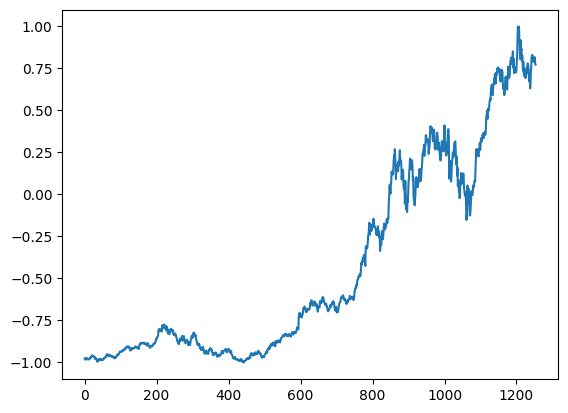

In [ ]:
## a view of Nvidia stocks and its complexity
plt.plot(scaled_data)
plt.show()

In [ ]:
# Fixed Data Pipeline
def sequences(data, window_size, ar_lags):
    X, y, X_ar = [], [], []
    # Need ar_lags + window_size points to create both inputs
    for i in range(ar_lags + window_size, len(data)):
        # AR lags: the 5 prices immediately before the sequence
        X_ar.append(data[i-window_size-ar_lags:i-window_size].flatten())
        # LSTM sequence: the main 60-day window
        X.append(data[i-window_size:i])
        # Target: next price after the sequence
        y.append(data[i])
    return np.array(X), np.array(y), np.array(X_ar)

In [ ]:
# splitting data into 2 streams to feed into the AR model and LSTM-CNN architecture
WINDOW_SIZE = 120
AR_LAGS = 10
VAL_SIZE = 30
TEST_SIZE = 60

X, y, X_ar = sequences(scaled_data, WINDOW_SIZE, AR_LAGS)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_ar = torch.tensor(X_ar, dtype=torch.float32)

n = len(X)
train_end = n - (VAL_SIZE + TEST_SIZE)
val_end = n - TEST_SIZE

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]
x_lags_train, x_lags_val, x_lags_test = (
    X_ar[:train_end],
    X_ar[train_end:val_end],
    X_ar[val_end:]
)

In [ ]:
## eventhough this is the final model ive added LSTM for comparison
## A pure LSTM model, no extras, first attempt at project
class NvidiaStockPredictor_LSTM(nn.Module):
  def __init__(self,input_size=1, hidden_size=100, output_size=1, num_layers=2):
    super(NvidiaStockPredictor_LSTM,self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.lstm=nn.LSTM(input_size,hidden_size, num_layers, batch_first=True, dropout=0.2)
    self.linear=nn.Linear(hidden_size,output_size)
    self.fc=nn.Linear(hidden_size,output_size)
  def forward(self, x):
    if isinstance(x, dict):
        x = x['features']

    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
## creating model, and deciding loss function, optimizer. decided to use a scheduler to control the learning rate
model=NvidiaStockPredictor_LSTM()
loss_fn = nn.HuberLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [ ]:
# basic training loop for pure LSTM  model
epochs=50
for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()
  y_pred=model(X_train)
  loss=loss_fn(y_pred,y_train)
  loss.backward()
  optimizer.step()
  scheduler.step(loss)
  if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:3}, Loss: {loss.item():.8f}, LR: {current_lr}")

Epoch  10, Loss: 0.09312076, LR: 0.001
Epoch  20, Loss: 0.05474079, LR: 0.001
Epoch  30, Loss: 0.01515587, LR: 0.001
Epoch  40, Loss: 0.00740701, LR: 0.001
Epoch  50, Loss: 0.00326662, LR: 0.001


In [ ]:
MODEL_PATH= "Pure_LSTM.pth"
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
# The final decided model which is a combination of LSTM, CNN and AR
class NvidiaStockPredictor_LSTM_CNN_AR_Hybrid(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, output_size=7, num_layers=2, ar_lags=10):
        super().__init__()
        # AR layer
        self.ar_lags = ar_lags
        self.ar = nn.Linear(ar_lags, output_size)

        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1, dilation=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        # LSTM
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        # Normalises to prevent vanishing and exploding gradients
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Residual head
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_size)
        )
        # a residual scale to give more importance to AR model to avoid hallucinating trends
        self.residual_scale = nn.Parameter(torch.full((1,), 0.1))

    def forward(self, x_seq, x_lags):
        x = x_seq.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)

        lstm_out, _ = self.lstm(x)
        last_hidden = self.layer_norm(lstm_out[:, -1, :])

        base_trend = self.ar(x_lags)
        nonlinear_res = self.head(last_hidden)

        return base_trend + nonlinear_res

In [ ]:
# defining loss fn= Hubert loss, optimizer= ADAM and using scheduler to control learning rate
modelv2=NvidiaStockPredictor_LSTM_CNN_AR_Hybrid()
loss_fn=nn.HuberLoss( delta=1.0)
optimizer=torch.optim.Adam(modelv2.parameters(),lr=0.001, weight_decay=1e-5)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=5,factor=0.5)

In [ ]:
## the same training loop as before
modelv2.train()
epochs=200
patience=20
best_loss=float('inf')
counter=0
for epoch in range (epochs):
  optimizer.zero_grad()
  y_preds = modelv2(X_train, x_lags_train)
  loss = loss_fn(y_preds, y_train.view(-1, 1))
  loss.backward()
  torch.nn.utils.clip_grad_norm_(modelv2.parameters(), max_norm=1.0)
  optimizer.step()
  modelv2.eval()
  with torch.no_grad():
    val_preds = modelv2(X_val, x_lags_val)
    val_loss = loss_fn(val_preds, y_val)
  scheduler.step(loss)

  if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        counter = 0
        torch.save(modelv2.state_dict(), 'best_hybrid_model.pth')
  else:
    counter += 1

  if counter >= patience:
    print(f"Stopping early at epoch {epoch+1} (Best Val Loss: {best_loss:.6f})")
    break

  if (epoch + 1) % 10 == 0:
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f} | Lr: {current_lr}")

modelv2.load_state_dict(torch.load('best_hybrid_model.pth'))
modelv2.eval()
with torch.no_grad():
    y_test_preds = modelv2(X_test, x_lags_test)
    test_loss = loss_fn(y_test_preds, y_test.view(-1, 1))
    print(f"\nFinal Test Loss: {test_loss.item():.6f}")

Epoch 10 | Train Loss: 0.023553 | Val Loss: 0.103726 | Lr: 0.001
Epoch 20 | Train Loss: 0.018511 | Val Loss: 0.119596 | Lr: 0.0005
Epoch 30 | Train Loss: 0.013902 | Val Loss: 0.081104 | Lr: 0.0005
Epoch 40 | Train Loss: 0.011102 | Val Loss: 0.053167 | Lr: 0.0005
Epoch 50 | Train Loss: 0.009569 | Val Loss: 0.031013 | Lr: 0.0005
Epoch 60 | Train Loss: 0.008861 | Val Loss: 0.023043 | Lr: 0.0005
Epoch 70 | Train Loss: 0.008250 | Val Loss: 0.018724 | Lr: 0.0005
Epoch 80 | Train Loss: 0.007739 | Val Loss: 0.015263 | Lr: 0.0005
Epoch 90 | Train Loss: 0.007289 | Val Loss: 0.014343 | Lr: 0.0005
Epoch 100 | Train Loss: 0.006972 | Val Loss: 0.013547 | Lr: 0.0005
Epoch 110 | Train Loss: 0.006492 | Val Loss: 0.012795 | Lr: 0.0005
Epoch 120 | Train Loss: 0.006042 | Val Loss: 0.012258 | Lr: 0.0005
Epoch 130 | Train Loss: 0.005653 | Val Loss: 0.011592 | Lr: 0.0005
Epoch 140 | Train Loss: 0.005277 | Val Loss: 0.010812 | Lr: 0.0005
Epoch 150 | Train Loss: 0.004938 | Val Loss: 0.009951 | Lr: 0.0005
Epoch

In [ ]:
#Saving the model
modelv2_PATH = "cnn_hybrid_model.pth"
torch.save(modelv2.state_dict(), modelv2_PATH)

In [ ]:
## Now Model is done training, I define some functions as required by th ps to apply to all the models- AR, VAR, MA, pure LSTM,
## and Hybrid. This one below collects all the predictions and the actual data
def rolling_forecast_validation(model, X_test_arg, y_test_arg, x_lags_test_arg=None, scalar_arg=None, device ="cuda"):
  """
    Perform rolling window validation on test set for Hybrid LSTM-Transformer.

    Args:
        model: Trained Hybrid LSTM-Transformer model
        X_test_arg: Test features (numpy array or tensor)
        y_test_arg: Test targets (numpy array)
        x_lags_test_arg: Test AR lags (numpy array or tensor), optional
        scalar_arg: MinMaxScaler for inverse transformation
        device: 'cuda' or 'cpu'

    Returns:
        predictions, actuals, metrics dict
    """
  predictions=[]
  actuals=[]
  model.eval()
  model.to(device)
  print("\nPerforming Rolling Forecast Validation...")
  for i in range(len(X_test_arg)):
    if isinstance(X_test_arg, np.ndarray):
      current_window_x_seq = torch.FloatTensor(X_test_arg[i:i+1]).to(device)
    else:
      current_window_x_seq = X_test_arg[i:i+1].to(device)

    with torch.no_grad():
      if x_lags_test_arg is not None:
          current_window_x_lags = x_lags_test_arg[i:i+1].to(device)
          prediction=model(current_window_x_seq, current_window_x_lags)
      else:
          prediction=model(current_window_x_seq)

    pred_value=prediction.cpu().numpy()[0,0]
    actual_value=y_test_arg[i,0]
    predictions.append(pred_value)
    actuals.append(actual_value)

  predictions = np.array(predictions)
  actuals = np.array(actuals)

  if scalar_arg is not None:
        predictions = scalar_arg.inverse_transform(predictions.reshape(-1, 1)).flatten()
        actuals = scalar_arg.inverse_transform(actuals.reshape(-1, 1)).flatten()


  rmse = np.sqrt(mean_squared_error(actuals, predictions)) ## this is the root mean square
  mae = mean_absolute_error(actuals, predictions) ## mean absolute error
  mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100 ## mean absolute percentage

  metrics = {
      'RMSE': rmse,
      'MAE': mae,
      'MAPE': mape
    }

  print(f"Rolling Forecast Validation Complete")
  return predictions, actuals, metrics

In [ ]:
## function to calculate other averages like root mean- RME, mean avarage- MAE, mean avarege percentage- MAPE, and mean, standard error
def analyze_performance(predictions, actuals, eps=1e-8):
    """
    Universal performance analysis for any forecasting model.

    Args:
        predictions (array-like): Model predictions
        actuals (array-like): Ground truth values
        eps (float): Small constant to avoid division by zero

    Returns:
        dict: Dictionary containing evaluation metrics
    """

    # Convert to 1D numpy arrays
    predictions = np.asarray(predictions).reshape(-1)
    actuals = np.asarray(actuals).reshape(-1)

    # Ensure same length
    assert len(predictions) == len(actuals), "Predictions and actuals must have same length"

    # Errors
    errors = actuals - predictions
    abs_errors = np.abs(errors)

    # Percentage errors (safe)
    pct_errors = abs_errors / (np.abs(actuals) + eps) * 100

    # Directional accuracy
    if len(actuals) > 1:
        actual_direction = np.sign(np.diff(actuals))
        pred_direction = np.sign(np.diff(predictions))
        directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    else:
        directional_accuracy = np.nan

    metrics = {
        "RMSE": np.sqrt(mean_squared_error(actuals, predictions)),
        "MAE": mean_absolute_error(actuals, predictions),
        "MAPE (%)": np.mean(pct_errors),
        "Mean Error": np.mean(errors),
        "Std Error": np.std(errors),
        "Max Error": np.max(abs_errors),
        "Min Error": np.min(abs_errors),
        "Median Error": np.median(abs_errors),
        "Directional Accuracy (%)": directional_accuracy,
        "Best Prediction Error": np.min(abs_errors),
        "Worst Prediction Error": np.max(abs_errors),
    }

    return metrics


In [ ]:
## just a function to plot all of what I've done till now in the form of a graph
def plot_forcast(predictions, actuals, title, save_path='forecast.png'):
  """
  Create comprehensive visualization of  model performance.

  Args:
    predictions: Model predictions
    actuals: Actual values
    save_path: Path to save figure
  """
  predictions=np.array(predictions)
  actuals=np.array(actuals)
  errors=actuals-predictions
  fig=plt.figure(figsize=(16,12))
  gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

  ax1=fig.add_subplot(gs[0, :])
  x=np.arange(len(actuals))
  ax1.plot(x, actuals, 'k-', linewidth=2.5, label='Actual Price', marker='o', markersize=4)
  ax1.plot(x, predictions, 'b--', linewidth=2.5, label='Prediction', marker='s', markersize=4)
  ax1.fill_between(x, actuals, predictions, alpha=0.2, color='gray')
  ax1.set_title('Stock Price Forecast', fontsize=14, fontweight='bold')
  ax1.set_xlabel('Time Steps (Days)', fontsize=11)
  ax1.set_ylabel('Price (USD)', fontsize=11)
  ax1.legend(fontsize=11, loc='best')
  ax1.grid(True, alpha=0.3)

  ax2=fig.add_subplot(gs[1,0])
  ax2.bar(x, errors, color=['red' if e < 0 else 'green' for e in errors], alpha=0.7, edgecolor='black')
  ax2.axhline(y=0, color='black', linestyle='--')
  ax2.set_title('Errors', fontsize=14, fontweight='bold')
  ax2.set_xlabel('Time Steps (Days)', fontsize=11)
  ax2.set_ylabel('Error (USD)', fontsize=11)
  ax2.grid(True, alpha=0.3)

  ax3=fig.add_subplot(gs[1,1])
  pct_errors=np.abs(actuals-predictions)/actuals*100
  ax3.bar(x, pct_errors, color=['red' if e < 0 else 'green' for e in pct_errors], alpha=0.7, edgecolor='black')
  ax3.axhline(y=0, color='black', linestyle='--')
  ax3.set_title('Percentage Errors', fontsize=14, fontweight='bold')
  ax3.set_xlabel('Time Steps (Days)', fontsize=11)
  ax3.set_ylabel('Error (%)', fontsize=11)
  ax3.grid(True, alpha=0.3, axis='y')

  ax4=fig.add_subplot(gs[2,0])
  ax4.bar(x, errors, color=['red' if e < 0 else 'green' for e in errors], alpha=0.7, edgecolor='black')
  ax4.axhline(y=0, color='black', linestyle='--')
  ax4.set_title('Errors over time', fontsize=14, fontweight='bold')
  ax4.set_xlabel('Time Steps (Days)', fontsize=11)
  ax4.set_ylabel('Error (USD)', fontsize=11)
  ax4.grid(True, alpha=0.3)

  ax5=fig.add_subplot(gs[2,1])
  window=7
  rolling_rmse = [np.sqrt(mean_squared_error(actuals[max(0, i-window):i+1],
                                               predictions[max(0, i-window):i+1]))
                    for i in range(len(actuals))]
  ax5.plot(x, rolling_rmse, 'o-', color='darkgreen', linewidth=2, markersize=6)
  ax5.axhline(y=np.mean(rolling_rmse), color='red', linestyle='--', linewidth=2, label=f'Mean: ${np.mean(rolling_rmse):.2f}')
  ax5.set_title(f'Rolling RMSE (Window={window})', fontsize=12, fontweight='bold')
  ax5.set_xlabel('Time Steps', fontsize=11)
  ax5.set_ylabel('Rolling RMSE (USD)', fontsize=11)
  ax5.legend(fontsize=10)
  ax5.grid(True, alpha=0.3)

  plt.savefig(save_path, dpi=300, bbox_inches='tight')
  print(f"\n✓ Visualization saved to: {save_path}")
  plt.show()


In [ ]:
predictions_LSTM, actuals_LSTM, metrics_LSTM = rolling_forecast_validation(model, X_test, y_test, scalar_arg=scaler, device=device)
predictions_AR_LSTM_Hybrid, actuals_AR_LSTM_Hybrid, metrics_AR_LSTM_Hybrid = rolling_forecast_validation(modelv2, X_test, y_test, x_lags_test_arg=x_lags_test, scalar_arg=scaler, device=device)


Performing Rolling Forecast Validation...
Rolling Forecast Validation Complete

Performing Rolling Forecast Validation...
Rolling Forecast Validation Complete



--- Final Model Comparison Table ---
                        RMSE       MAE        MAPE
Model                                             
Hybrid LSTM-ar-cnn    8.5710    6.0920    609.1977
AR Model              9.5450    7.4130    741.2997
MA Model            123.5473  123.0641  12306.4115
Naive (Baseline)      9.8582    7.2192    721.9167
RW w/ Drift           8.9151    6.1810    618.1031
Pure LSTM            23.6199   22.5478   2254.7752


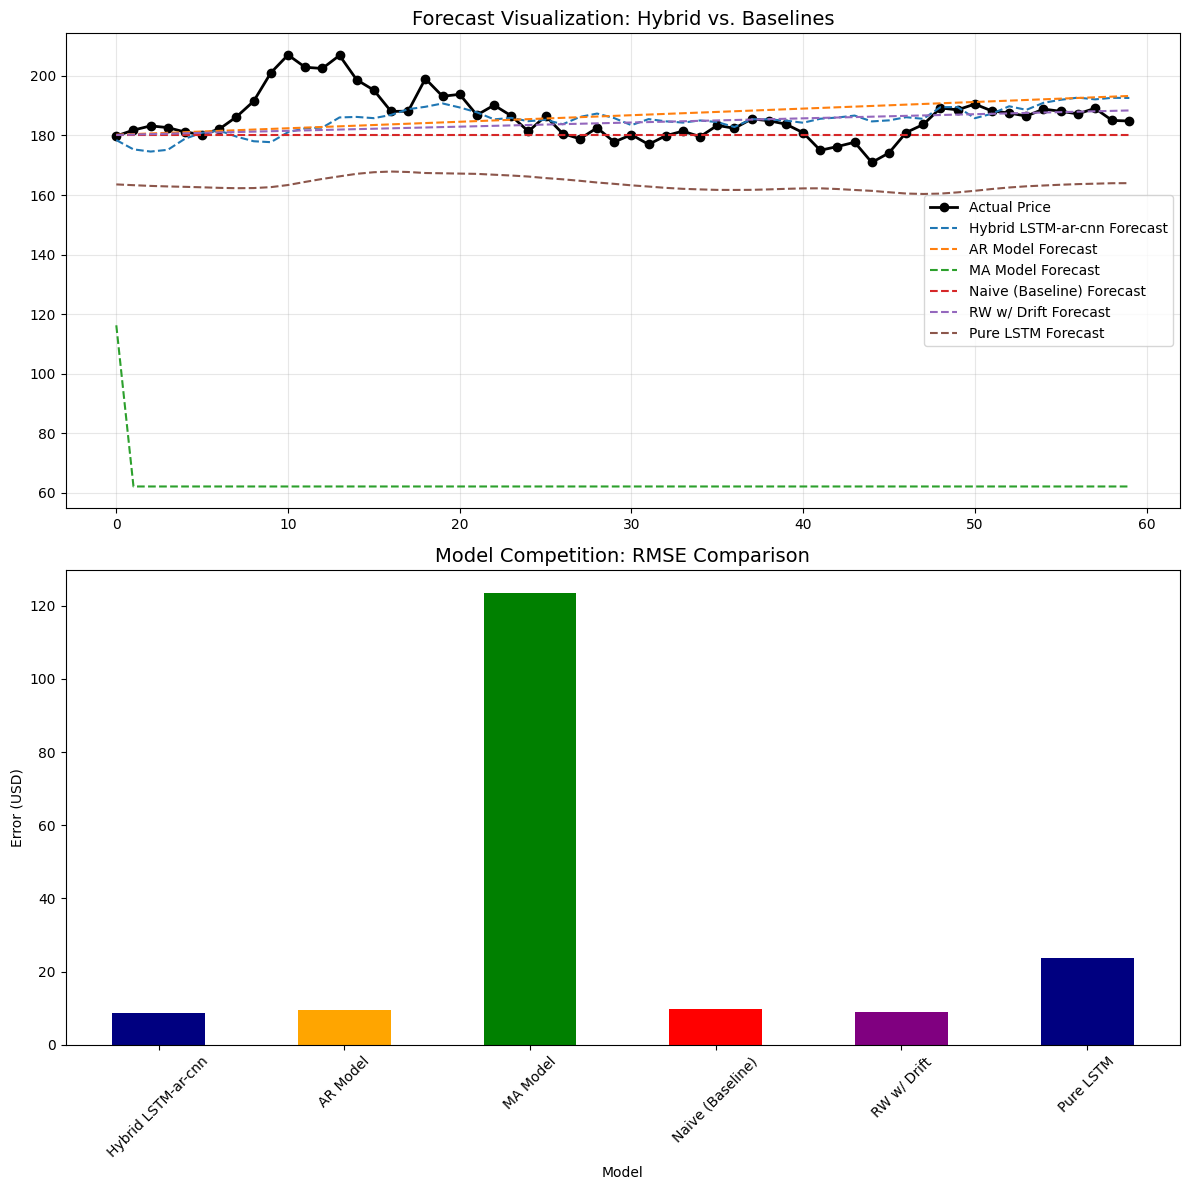

In [ ]:
# to compare all models
hybrid_preds = predictions_AR_LSTM_Hybrid
history_for_baselines = data[:-TEST_SIZE]
actuals = data[-TEST_SIZE:]

# Model 1: Hybrid LSTM-ar-cnn (Your existing predictions)
# Now using the defined hybrid_preds

# Model 2: AR (Autoregressive)
ar_model = AutoReg(history_for_baselines, lags=1).fit()
ar_preds = ar_model.forecast(steps=TEST_SIZE) # Use TEST_SIZE

# Model 3: MA (Moving Average)
ma_model = ARIMA(history_for_baselines, order=(0, 0, 1)).fit()
ma_preds = ma_model.forecast(steps=TEST_SIZE) # Use TEST_SIZE

# Model 4: VAR (Vector Autoregression - simplified as Naive for this example)
naive_preds = np.repeat(history_for_baselines[-1], TEST_SIZE) # Use TEST_SIZE

# Model 5: Random Walk with Drift
drift = (history_for_baselines[-1] - history_for_baselines[0]) / len(history_for_baselines)
rw_preds = history_for_baselines[-1] + np.arange(1, TEST_SIZE + 1) * drift # Use TEST_SIZE

# Model 7: Pure LSTM
lstm_preds = predictions_LSTM


models = {
    "Hybrid LSTM-ar-cnn": hybrid_preds,
    "AR Model": ar_preds,
    "MA Model": ma_preds,
    "Naive (Baseline)": naive_preds,
    "RW w/ Drift": rw_preds,
    "Pure LSTM": lstm_preds
}


metrics_list = []
for name, preds in models.items():
    metrics_list.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(actuals, preds)),
        "MAE": mean_absolute_error(actuals, preds),
        "MAPE": mean_absolute_error(actuals, preds) * 100
    })

df_comparison = pd.DataFrame(metrics_list).set_index("Model")


print("\n Final Model Comparison Table")
print(df_comparison.round(4))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Forecast Visualization
ax1.plot(actuals, label="Actual Price", color='black', linewidth=2, marker='o')
for name, preds in models.items():
    ax1.plot(preds, label=f"{name} Forecast", linestyle='--')
ax1.set_title("Forecast Visualization: Hybrid vs. Baselines", fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Bar Chart Comparisons (RMSE)
df_comparison['RMSE'].plot(kind='bar', ax=ax2, color=['navy', 'orange', 'green', 'red', 'purple'])
ax2.set_title("Model Competition: RMSE Comparison", fontsize=14)
ax2.set_ylabel("Error (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()